# Imports

In [1]:

# Imports
import logging
logging.basicConfig(
    level=logging.INFO
)

import warnings
warnings.filterwarnings('ignore')

from typing import Union, Iterable, Optional

import argparse
from argparse import Namespace

import os
import os.path
import shutil
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import math
import json

import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import json
import os
from dataclasses import dataclass

from openmm.unit import bar, mole, litre, kelvin, kilojoule_per_mole, nanometer, angstrom, kilocalorie_per_mole, kilogram, molar, atmosphere, nanosecond, picosecond, femtoseconds
from openmm.unit import Quantity, Unit
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB



from salt_data import SaltData, salt_infos

INFO:numexpr.utils:NumExpr defaulting to 16 threads.


# Constants

In [2]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA # gas constant

In [3]:
def osm_experimental(exp_osm_coeff, molarity:Quantity=1*(mole/litre), vant_hoff=2, T=300*kelvin):
    osm_press_ideal=vant_hoff*molarity*R*T
    osm_press_ideal=osm_press_ideal.in_units_of(bar)
    osm_bar=exp_osm_coeff*osm_press_ideal
    op_error=(abs(osm_bar-osm_press_ideal)/osm_press_ideal)*100
    print(f'Ideal Osmotic Pressure: {osm_press_ideal} at concentraion {molarity}')
    print(f'Osmotic Pressure from experimental osmotic coefficient: {osm_bar}')
    return osm_bar


In [4]:
def extract_experiment_data(data, salt):
    """
    Extracts molarity values and their corresponding osmotic coefficients
    for a given salt and stores them in two separate lists.
    
    Parameters:
        data (dict): The dictionary containing salt data.
        salt (str): The name of the salt (e.g., "NaCl").

    Returns:
        molarity_list (list): List of molarity values.
        osmotic_coeff_list (list): List of corresponding osmotic coefficients.
    """
    molarity_list = []
    osmotic_coeff_list = []

    if salt in data:
        for molality_key, values in data[salt].items():
            molarity_list.append(values["Molarity"])
            osmotic_coeff_list.append(values["Osmotic Coefficient"])
    else:
        print(f"Salt '{salt}' not found in data.")

    return molarity_list, osmotic_coeff_list

In [5]:
def load_salt_info(ion1, ion2):
    """
    Load all data entries for a specific salt from salt_info and return them as a dictionary
    where the salt appears only once with a subdictionary containing all its data.
    """
    salt = ion1 + ion2
    print(f"Salt to be analyzed: {salt}")

    # Convert dictionaries into SaltData instances
    salt_info_cleaned = [SaltData(**entry) if isinstance(entry, dict) else entry for entry in salt_infos]

    

    # Filter all entries that match the requested salt and store in a subdictionary
    filtered_entries = {
        f"Molality {entry.molality} mol/kg": {
            "Molarity": entry.molarity,
            "Number of Particles": math.ceil(entry.num_particles),
            "Osmotic Coefficient": entry.osmotic_coefficient,
        }
        for entry in salt_info_cleaned if entry.salt == salt
    }

    # Return results with the salt name as the top-level key
    if filtered_entries:
        return {salt: filtered_entries}
    else:
        return {"Error": f"No data found for {salt}"}


In [6]:
@dataclass
class IonMolalInfo:
    '''For representing info about the systems' molecular composition'''
    salt : str
    ion1 : str
    ion2 : str
    molalities : list
    vantHoff : int
    colors : list

In [7]:
molal_infos = {
    1 : IonMolalInfo(
        salt='NaCl',
        ion1 = 'Na',
        ion2 = 'Cl',
        molalities = [0.1,0.5,1.0,1.4,2.0,2.5,3.0,3.5,4.0],
        vantHoff = 2,
        colors=['darkgreen','lime','limegreen']
    ),
    2 : IonMolalInfo(
        salt='CsBr',
        ion1 = 'Cs',
        ion2 = 'Br',
        molalities = [0.1,0.5,1.0,1.4,2.0,2.5,3.0,3.5,4.0],
        vantHoff = 2,
        colors=['mediumvioletred','violet','m']
    ),
    3 : IonMolalInfo(
        salt='MgCl',
        ion1 = 'Mg',
        ion2 = 'Cl',
        molalities = [0.1,0.5,1.0,1.4,2.0,2.5,3.0,3.5,4.0],
        vantHoff = 3,
        colors=['darkblue','cyan','b']
    ),
    4 : IonMolalInfo(
        salt='NaNO3',
        ion1 = 'Na',
        ion2 = 'NO3',
        molalities = [0.1,0.5,1.0,1.4,2.0,2.5,3.0,3.5,4.0],
        vantHoff = 2,
        colors=['darkgoldenrod','goldenrod','gold']
    ),
    5 : IonMolalInfo(
        salt='NH4NO3',
        ion1 = 'NH4',
        ion2 = 'NO3',
        molalities = [0.1,0.5,1.0,1.4,2.0,2.5,3.0,3.5,4.0],
        vantHoff = 2,
        colors=['maroon','indianred','lightcoral']
    ),
}

In [8]:
water='TIP3P'
ff_used = f'Sage 2.1 + {water}'
vantHoff=2
N_replicates=20

In [9]:
molal_infos

{1: IonMolalInfo(salt='NaCl', ion1='Na', ion2='Cl', molalities=[0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0], vantHoff=2, colors=['darkgreen', 'lime', 'limegreen']),
 2: IonMolalInfo(salt='CsBr', ion1='Cs', ion2='Br', molalities=[0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0], vantHoff=2, colors=['mediumvioletred', 'violet', 'm']),
 3: IonMolalInfo(salt='MgCl', ion1='Mg', ion2='Cl', molalities=[0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0], vantHoff=3, colors=['darkblue', 'cyan', 'b']),
 4: IonMolalInfo(salt='NaNO3', ion1='Na', ion2='NO3', molalities=[0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0], vantHoff=2, colors=['darkgoldenrod', 'goldenrod', 'gold']),
 5: IonMolalInfo(salt='NH4NO3', ion1='NH4', ion2='NO3', molalities=[0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0], vantHoff=2, colors=['maroon', 'indianred', 'lightcoral'])}

In [10]:
salt_info_dict={}

for i in molal_infos:
    salt_info_dict[f'{molal_infos[i].salt}']=load_salt_info(f'{molal_infos[i].ion1}', f'{molal_infos[i].ion2}')

Salt to be analyzed: NaCl
Salt to be analyzed: CsBr
Salt to be analyzed: MgCl
Salt to be analyzed: NaNO3
Salt to be analyzed: NH4NO3


# Utility Functions

In [11]:
def load_results(ion1,ion2,molalities,calc_type):
    calc_type = calc_type.lower()
    # Get the directory of the current script
    script_dir = os.getcwd()

    if calc_type in ['fbp', 'fbps']:
        fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []
        for mol in molalities:
            if mol % 1 == 0:
                mi1 = f"{mol:.1f}"
                mi = str(int(mol))  # Whole number: strip decimal
            else:
                mi = f"{mol:.1f}".replace('.', '')  # Float: remove the dot
                mi1 = f"{mol:.1f}"  # used in salt_dict key lookup

            # Initialize lists for OP and OC values and errors
            # fbp_op_values, fbp_op_errors, fbp_oc_values, fbp_oc_errors = [], [], [], []

            relative_path = os.path.join(script_dir, fbp_dir, f'FBP_{ion1}{ion2}_{water}',f'final_results_{mi}m.json')

            # Open and load the JSON file
            with open(relative_path, 'r') as file:
                results_json = json.load(file)

            # Append values and errors to respective lists
            fbp_op_values.append(results_json['mean_osmotic_pressure'])
            fbp_op_errors.append(results_json['uncertainty_osmotic_pressure'])
            fbp_oc_values.append(results_json['mean_osmotic_coefficient'])
            fbp_oc_errors.append(results_json['uncertainty_osmotic_coefficient'])

        # Create and return the dictionary
        return {
            "Concentrations": molalities,
            "OP_Values": fbp_op_values,
            "OP_Errors": fbp_op_errors,
            "OC_Values": fbp_oc_values,
            "OC_Errors": fbp_oc_errors
        }

    elif calc_type in ['hp', 'hps']:
        # Initialize lists for OP and OC values and errors
        hp_conc_values,hp_op_values, hp_op_errors, hp_oc_values, hp_oc_errors = [],[], [], [], []
        mi='4'
        # Construct the file path
        relative_path = os.path.join(script_dir, hp_dir, f'HP_{ion1}{ion2}_{water}', f'result_files_{mi}m',f'{ion1}{ion2}_final_results_{mi}m.csv')
        results_csv=pd.read_csv(relative_path)

        # Find where the values in any of the key result columns start repeating
        dup_mask = results_csv.duplicated(subset=[
            'Osmotic Coefficient',
            'Osmotic Coefficient Error',
            'Osmotic Pressure',
            'Osmotic Pressure Error'
        ], keep='first')

        # Find first index where duplication starts
        first_dup_index = dup_mask.idxmax() if dup_mask.any() else len(results_csv)

        # Truncate the DataFrame up to the first duplicate
        results_sub = results_csv.iloc[:first_dup_index]

        print(results_sub)
        # Loop through the data in the JSON lists
        for concs, op, op_err, oc, oc_err in zip(
            results_sub['Molality'],
            results_sub['Osmotic Pressure'],
            results_sub['Osmotic Pressure Error'],
            results_sub['Osmotic Coefficient'],
            results_sub['Osmotic Coefficient Error']):
            
            # Append values and errors to respective lists
            hp_conc_values.append(concs)
            hp_op_values.append(op)
            hp_op_errors.append(op_err)
            hp_oc_values.append(oc)
            hp_oc_errors.append(oc_err)

        # Create and return the dictionary
        return {
            "Concentrations": hp_conc_values,
            "OP_Values": hp_op_values,
            "OP_Errors": hp_op_errors,
            "OC_Values": hp_oc_values,
            "OC_Errors": hp_oc_errors
        }


## Load results from json files

In [12]:
fbp_dir='/media/bamo6610/DATA/openff-dev/FBP_final'
hp_dir='/media/bamo6610/DATA/openff-dev/HP_final'

In [13]:
salt_results_dict={}

for i in molal_infos:
    salt_results_dict[f'FBP-{molal_infos[i].salt}']=load_results(f'{molal_infos[i].ion1}', f'{molal_infos[i].ion2}', molal_infos[i].molalities, 'fbps')
    salt_results_dict[f'HP-{molal_infos[i].salt}']=load_results(f'{molal_infos[i].ion1}', f'{molal_infos[i].ion2}', molal_infos[i].molalities, 'hps')

    Molality  Osmotic Coefficient  Osmotic Coefficient Error  \
0        0.1             0.939913                   0.003094   
1        0.2             0.939953                   0.004000   
2        0.3             0.944598                   0.004344   
3        0.4             0.950848                   0.004370   
4        0.5             0.957884                   0.004289   
5        0.6             0.965360                   0.004079   
6        0.7             0.972978                   0.003802   
7        0.8             0.980723                   0.003566   
8        0.9             0.988478                   0.003378   
9        1.0             0.996277                   0.003178   
10       1.2             1.011913                   0.002775   
11       1.4             1.027473                   0.002754   
12       1.6             1.042829                   0.002872   
13       1.8             1.058211                   0.003402   
14       2.0             1.073285       

In [14]:
salt_results_dict['FBP-CsBr']

{'Concentrations': [0.1, 0.5, 1.0, 1.4, 2.0, 2.5, 3.0, 3.5, 4.0],
 'OP_Values': [4.688,
  23.692,
  49.286,
  70.915,
  103.664,
  133.848,
  165.722,
  192.84,
  229.323],
 'OP_Errors': [0.115, 0.295, 0.43, 0.863, 0.728, 1.016, 0.776, 1.134, 1.023],
 'OC_Values': [0.898, 0.939, 0.999, 1.032, 1.067, 1.115, 1.162, 1.165, 1.225],
 'OC_Errors': [0.022, 0.012, 0.009, 0.013, 0.008, 0.008, 0.005, 0.007, 0.005]}

## Experimental

In [15]:
def exp_plot(salt_dict,salt_name,vantHoff):
    # Experimental values of osmotic coefficient obtained from Hamer & Wu paper
    exp_concs, yexpOC = extract_experiment_data(salt_dict,salt_name)
    print(exp_concs)
    # Convert quantities to scalars in appropriate units for plotting
    exp_concs_values = [x*(molar) for x in exp_concs]

    # Experimental values of osmotic pressure obtained from Hamer & Wu paper
    yexpOP=[]
    for i,m in enumerate(exp_concs):
        op_res=osm_experimental(exp_osm_coeff=yexpOC[i], vant_hoff=vantHoff, molarity=exp_concs_values[i])
        yexpOP.append(op_res.value_in_unit(op_res.unit))
    
    return exp_concs, yexpOC, yexpOP

In [16]:
salt_experimental_dict = {}

for i in molal_infos:
    salt_name = molal_infos[i].salt
    exp_concs, exp_OC, exp_OP = exp_plot(
        salt_info_dict[salt_name],
        salt_name,
        molal_infos[i].vantHoff
    )
    salt_experimental_dict[salt_name] = {
        'concs': exp_concs,
        'OC': exp_OC,
        'OP': exp_OP
    }


[0.1, 0.2, 0.3, 0.4, 0.5, 0.601, 0.701, 0.801, 0.901, 1.001, 1.201, 1.401, 1.601, 1.802, 2.002, 2.502, 3.003, 3.503, 4.003, 4.504, 5.004, 5.505, 6.005]
Ideal Osmotic Pressure: 4.988677570891944 bar at concentraion 0.1 M
Osmotic Pressure from experimental osmotic coefficient: 4.649447496071293 bar
Ideal Osmotic Pressure: 9.977355141783889 bar at concentraion 0.2 M
Osmotic Pressure from experimental osmotic coefficient: 9.229053506150098 bar
Ideal Osmotic Pressure: 14.966032712675831 bar at concentraion 0.3 M
Osmotic Pressure from experimental osmotic coefficient: 13.798682161087116 bar
Ideal Osmotic Pressure: 19.954710283567778 bar at concentraion 0.4 M
Osmotic Pressure from experimental osmotic coefficient: 18.358333460882356 bar
Ideal Osmotic Pressure: 24.943387854459722 bar at concentraion 0.5 M
Osmotic Pressure from experimental osmotic coefficient: 22.972860213957404 bar
Ideal Osmotic Pressure: 29.98195220106058 bar at concentraion 0.601 M
Osmotic Pressure from experimental osmotic

## Plotting FBPs vs HP vs Experiments

In [17]:
# Formatting font size
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

In [18]:
def plot_results(salt_name,salt_info_dict,salt_experimental_dict, salt_results_FBP, salt_results_HP, color_list):
     # Osmotic coefficient plot
    plt.rcParams.update({'font.size': 16})
    plt.figure(figsize=(12.0,10.0))

    # Experimental data
    plt.plot(salt_experimental_dict['concs'], salt_experimental_dict['OC'], marker='o', linestyle='-', color=f'{color_list[0]}',
            label=f'{salt_name} Experimental (Hamer & Wu)', linewidth=3, markersize=8)
    # Flat-bottom Potentials data with error bars
    plt.errorbar(salt_results_FBP['Concentrations'], salt_results_FBP['OC_Values'], yerr=salt_results_FBP['OC_Errors'], 
                fmt='o', linestyle='-', color=f'{color_list[1]}', capsize=8, 
                label=f'{salt_name} Flat-bottom Potential', linewidth=3, markersize=8)
    # Harmonic Potentials data with error bars
    plt.errorbar(salt_results_HP['Concentrations'], salt_results_HP['OC_Values'], yerr=salt_results_HP['OC_Errors'], 
                fmt='o', linestyle='-', color=f'{color_list[2]}', capsize=8, 
                label=f'{salt_name} Harmonic Potentials', linewidth=3, markersize=8)

    plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
    plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
        # plt.xlim(0.5,3.5)
        # plt.ylim(0.75,1.10)
    plt.title(f'Osmotic Coefficients Sage 2.1 + TIP3P', fontsize=BIGGER_SIZE)
    plt.legend(prop={'size': 16}, loc='upper left')
    plt.grid()

        # plt.savefig('all_fbps_vs_hp_OCs.png')

    plt.show()

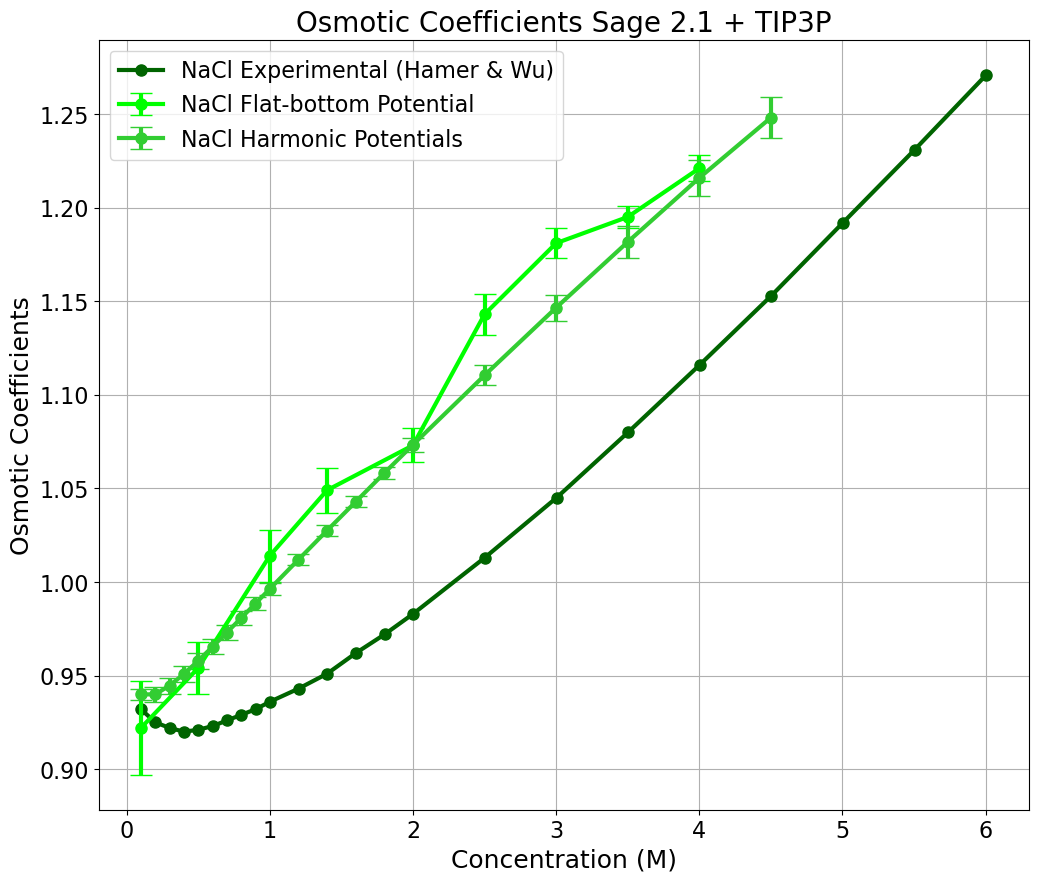

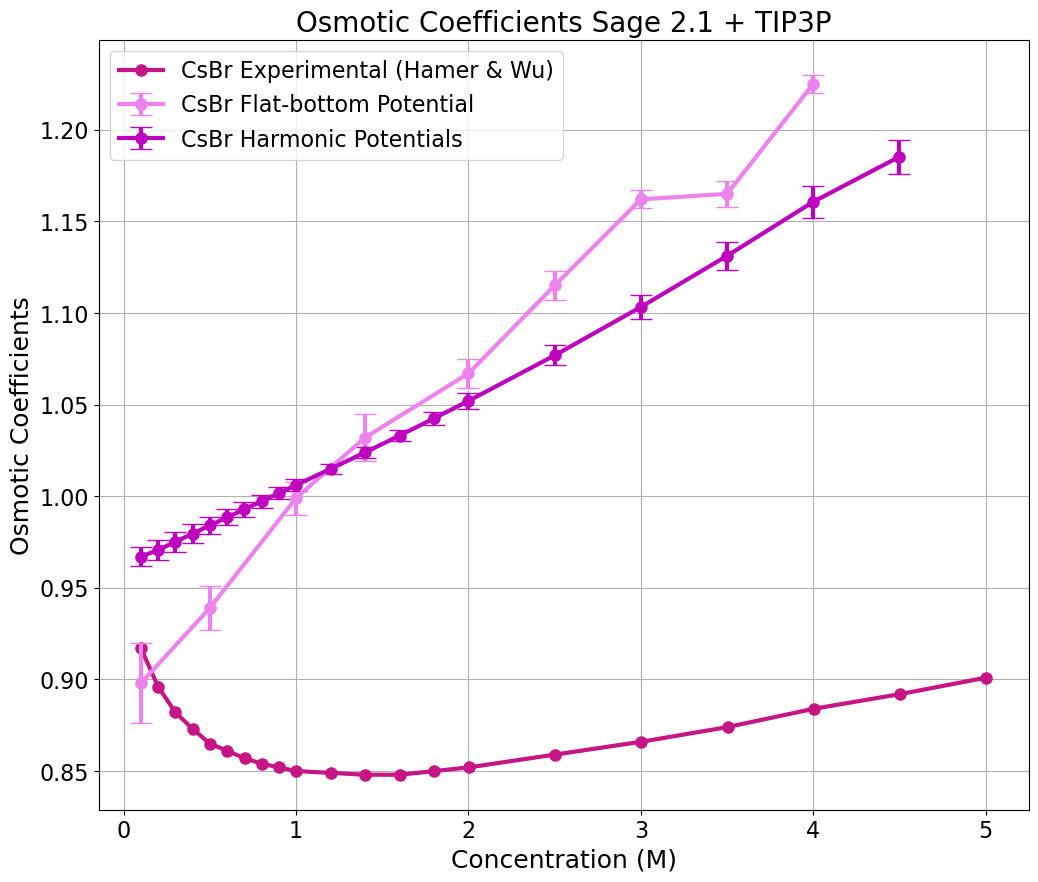

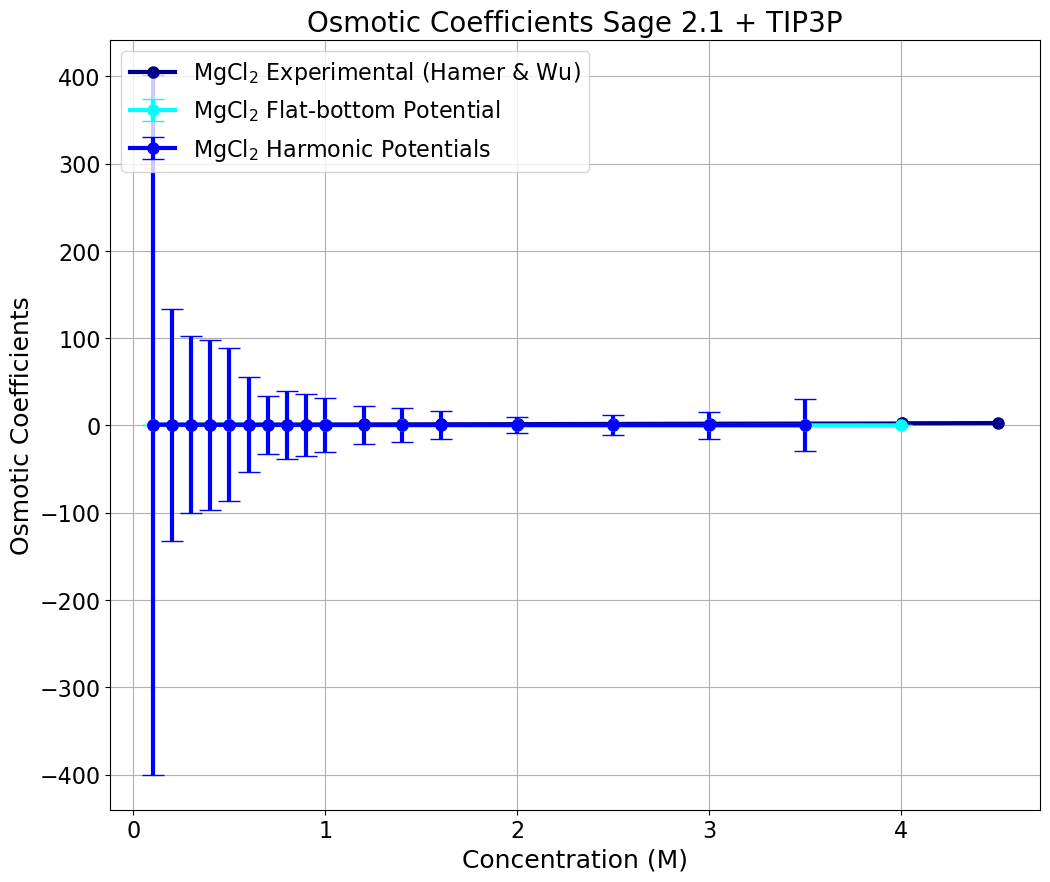

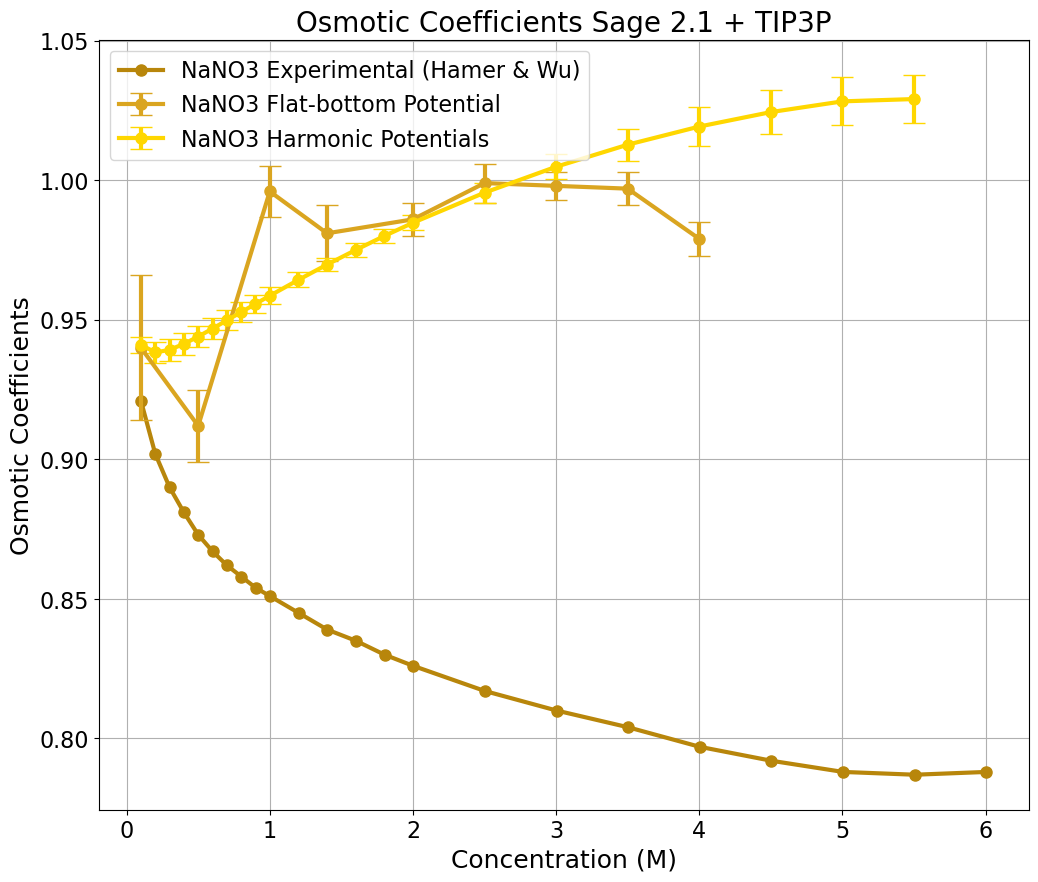

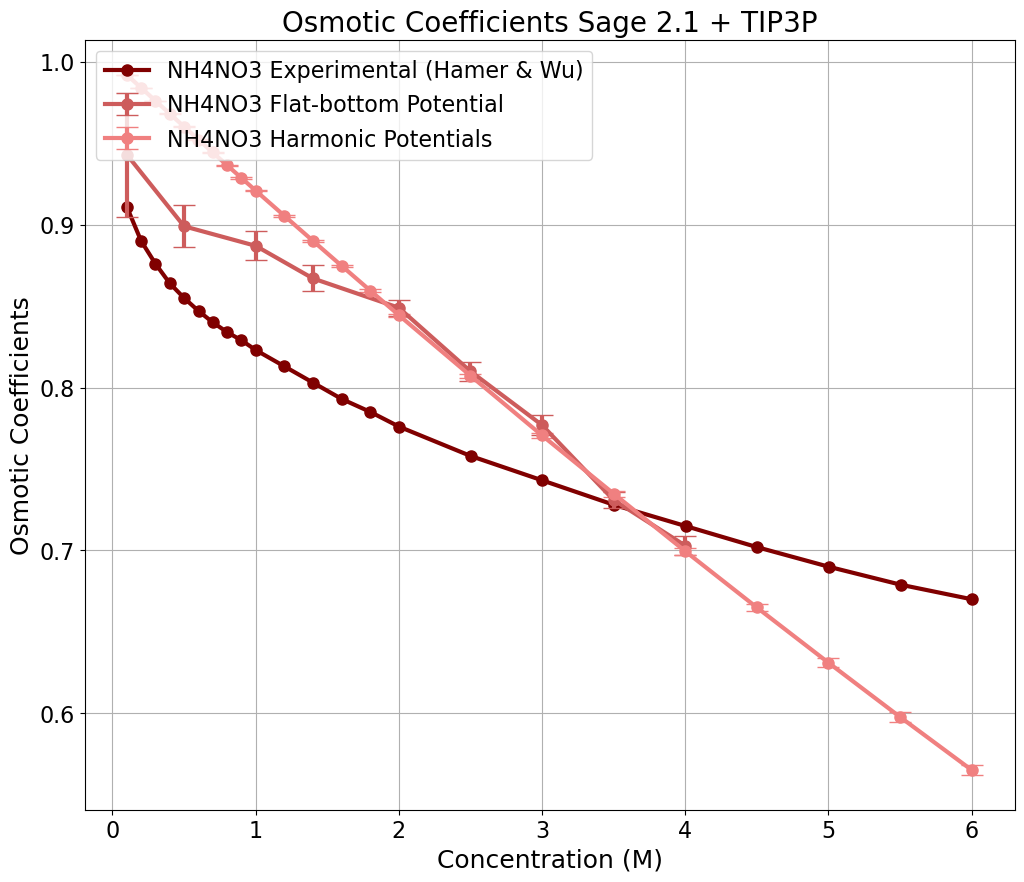

In [24]:
for i in molal_infos:
    salt_name = molal_infos[i].salt
    if salt_name != 'MgCl':
        plot_results(f'{salt_name}',salt_info_dict[f'{salt_name}'],salt_experimental_dict[f'{salt_name}'], salt_results_dict[f'FBP-{salt_name}'], salt_results_dict[f'HP-{salt_name}'], molal_infos[i].colors)
    else:
        plot_results(r'MgCl$_{2}$',salt_info_dict[f'{salt_name}'],salt_experimental_dict[f'{salt_name}'], salt_results_dict[f'FBP-{salt_name}'], salt_results_dict[f'HP-{salt_name}'], molal_infos[i].colors)
    

In [20]:
# Osmotic coefficient plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12.0,10.0))

# Experimental data
plt.plot(nacl_exp_concs, nacl_yexpOC, marker='o', linestyle='-', color='darkgreen',
         label='NaCl Experimental (Hamer & Wu)', linewidth=3, markersize=8)
# Flat-bottom Potentials data with error bars
plt.errorbar(nacl_hp_results['Concentrations'], nacl_hp_results['OC_Values'], yerr=nacl_hp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='lime', capsize=8, 
             label='NaCl Harmonic Potentials', linewidth=3, markersize=8)
# Harmonic Potentials data with error bars
plt.errorbar(molal_infos[1].molalities, nacl_fbp_results['OC_Values'], yerr=nacl_fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='limegreen', capsize=8, 
             label='NaCl Flat-bottom Potential', linewidth=3, markersize=8)


# Experimental data ['mediumvioletred','violet','m']
plt.plot(csbr_exp_concs, csbr_yexpOC, marker='o', linestyle='-', color='mediumvioletred',
         label='CsBr Experimental (Hamer & Wu)', linewidth=3, markersize=8)
# Flat-bottom Potentials data with error bars
plt.errorbar(csbr_hp_results['Concentrations'], csbr_hp_results['OC_Values'], yerr=csbr_hp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='violet', capsize=8, 
             label='CsBr Harmonic Potentials', linewidth=3, markersize=8)
# Harmonic Potentials data with error bars
plt.errorbar(molal_infos[2].molalities, csbr_fbp_results['OC_Values'], yerr=csbr_fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='m', capsize=8, 
             label='CsBr Flat-bottom Potential', linewidth=3, markersize=8)


# Experimental data ['darkblue','cyan','b']
plt.plot(nano3_exp_concs, nano3_yexpOC, marker='o', linestyle='-', color='darkblue',
         label='NaNO3 Experimental (Hamer & Wu)', linewidth=3, markersize=8)
# Flat-bottom Potentials data with error bars
plt.errorbar(nano3_hp_results['Concentrations'], nano3_hp_results['OC_Values'], yerr=nano3_hp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='cyan', capsize=8, 
             label='NaNO3 Harmonic Potentials', linewidth=3, markersize=8)
# Harmonic Potentials data with error bars
plt.errorbar(molal_infos[2].molalities, nano3_fbp_results['OC_Values'], yerr=nano3_fbp_results['OC_Errors'], 
             fmt='o', linestyle='-', color='b', capsize=8, 
             label='NaNO3 Flat-bottom Potential', linewidth=3, markersize=8)


plt.xlabel("Concentration (M)",fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Coefficients",fontsize=MEDIUM_SIZE)
# plt.xlim(0.5,3.5)
# plt.ylim(0.75,1.10)
plt.title(f'Osmotic Coefficients Sage 2.1 + TIP3P', fontsize=BIGGER_SIZE)
plt.legend(prop={'size': 16}, loc='upper left')
plt.grid()

plt.savefig('all_fbps_vs_hp_OCs.png')
# plt.savefig('nacl_fbps_vs_hp_OCs.png')
# plt.savefig('csbr_fbps_vs_hp_OCs.png')
# plt.savefig('nano3_fbps_vs_hp_OCs.png')

plt.show()

NameError: name 'nacl_exp_concs' is not defined

<Figure size 1200x1000 with 0 Axes>

In [ ]:
## Osmotic pressure plot
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(10,9))

# Experimental data
plt.plot(exp_concs_values, yexpOP, marker='o', linestyle='-', color='black',
         label='Experimental (Hamer & Wu)', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(concs_values, fbp_results['OP_Values'], yerr=fbp_results['OP_Errors'], 
             fmt='o', linestyle='-', color='magenta', capsize=8, 
             label='Flat-bottom Potentials - OpenFF', linewidth=3, markersize=8)

# Flat-bottom Potentials data with error bars
plt.errorbar(concs_values, nacl_hp_results['OP_Values'], yerr=nacl_hp_results['OP_Errors'], 
             fmt='o', linestyle='-', color='dodgerblue', capsize=8, 
             label='Harmonic Potentials - OpenFF', linewidth=3, markersize=8)

# Add labels to the calculated points
for i in range(len(concs_values)):
    x_val = concs_values[i]  # Scalar value
    y_val = fbp_results['OP_Values'][i]
    plt.text(x_val, y_val, f"({molalities[i]})", fontsize=12, ha='right')

# Add labels to the specific experimental points
special_labels = {0.98: '1m', 1.92: '2m', 2.82: '3m'}
for i in range(len(exp_concs_values)):
    x_val = exp_concs_values[i]  # Scalar value
    y_val = yexpOP[i]
    if x_val in special_labels:  # Check if x_val is in the special_labels dictionary
        plt.text(x_val, y_val, f"({special_labels[x_val]})", fontsize=12, ha='right')

plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel("Osmotic Pressure (bar)", fontsize=MEDIUM_SIZE)
plt.title('Osmotic Pressure for Increasing NaCl Concentration', fontsize=BIGGER_SIZE)
plt.legend()
plt.grid()
plt.savefig('fbps_vs_hp_OPs.png')
plt.show()

NameError: name 'exp_concs_values' is not defined

<Figure size 1000x900 with 0 Axes>